In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import time 

from data import Data_handler
from data_analysis import Data_analysis

# Data loading

In [2]:
data_handler = Data_handler()
train_set, valid_set, test_set = data_handler.read_all()

Bounding box: [113.19, 1291.88, 175.66, 1361.82]
Sign:  Yield


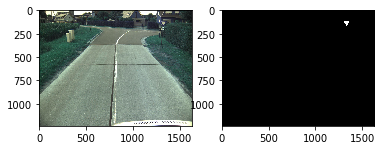

In [3]:
_, ax = plt.subplots(1,2)
image   = cv2.imread(train_set[0].img)
mask_im = cv2.imread(train_set[0].msk,0)
ax[0].imshow(image)
ax[1].imshow( cv2.cvtColor(mask_im, cv2.COLOR_GRAY2BGR)*255 )
print('Bounding box:',                          train_set[0].annotations[0][0])
sign_description = data_handler.parse_sign_type(train_set[0].annotations[0][1])
print('Sign: ', sign_description)
plt.show()

# Data Analysis

In [4]:
data_analysis = Data_analysis()
sign_count, max_area, min_area, filling_ratios, max_aspect_ratio, min_aspect_ratio = \
                    data_analysis.shape_analysis(train_set)

print('Train data size: ', len(train_set))
print('Valid data size: ', len(valid_set))
print('Test data size: ',  len(test_set))

data = {'Sign count':     [sign_count[sign_type]        for sign_type in data_handler.types],
        'filling ratios': [filling_ratios[sign_type][0] for sign_type in data_handler.types] }

keys_name = [sign_type + ' - ' + data_handler.parse_sign_type(sign_type) for sign_type in data_handler.types]

df = pd.DataFrame(data=data, index = keys_name)
df

Train data size:  254
Valid data size:  108
Test data size:  137


,Sign count,filling ratios
A - Red Triangle,68,0.501151
B - Yield,9,0.496846
C - Red Circle,31,0.784166
D - Blue Circle,49,0.777598
E - Red and Blue Circle,28,0.784584
F - Blue Square,92,1.000000


# Generate masks for the testset

In [ ]:
from traffic_signs.traffic_sign_detection import traffic_sign_detection
from traffic_sign_model import Traffic_sign_model

traffic_sign_model = Traffic_sign_model()
images_dir    = 'test/'
output_dir    = 'test_results/'
pixel_method  = 'hsvclosing'
window_method = 'None'

traffic_sign_detection('test', images_dir,test_set, output_dir,'hsvClosing',traffic_sign_model.pixel_method, window_method)


SyntaxError: invalid syntax (traffic_sign_detection.py, line 132)

# Testing on validation split and train splits

In [9]:
traffic_sign_model = Traffic_sign_model()
images_dir    = 'train/'
output_dir    = 'results/'
pixel_method  = 'hsvclosing'
window_method = 'None'

pixel_precision, pixel_accuracy, pixel_specificity, pixel_sensitivity, window_precision, window_accuracy =\
    traffic_sign_detection('val', images_dir,valid_set, output_dir,'hsvClosing',traffic_sign_model.pixel_method, window_method)

F1 = 2 * (pixel_precision * pixel_sensitivity) / (pixel_precision + pixel_sensitivity)
print('pixel_precision:  ',pixel_precision)
print('pixel_sensitivity:',pixel_sensitivity)
print('Accuracy', pixel_accuracy)
print('F1 =',F1)

pixel_precision:   0.638433918042493
pixel_sensitivity: 0.6430227141881577
Accuracy 0.9975849498442074
F1 = 0.6407201000549699


In [8]:
pixel_precision, pixel_accuracy, pixel_specificity, pixel_sensitivity, window_precision, window_accuracy =\
    traffic_sign_detection('val', images_dir,train_set, output_dir,'hsvClosing',traffic_sign_model.pixel_method, window_method)

F1 = 2 * (pixel_precision * pixel_sensitivity) / (pixel_precision + pixel_sensitivity)
print('pixel_precision:  ',pixel_precision)
print('pixel_sensitivity:',pixel_sensitivity)
print('F1 =',F1)

pixel_precision:   0.5059577501168169
pixel_sensitivity: 0.6386556210703788
F1 = 0.5646146887154972


# Tuning Hyperparameters

In [6]:
images_dir    = 'train/'
output_dir    = 'results/'
pixel_method  = 'hsvclosing'
window_method = 'None'
start_time = time.time()

bestf1          = 0
best_model = []

for red_low_hue in range(171,179,2):
    for red_high_hue in range(1,9,2):
        traffic_sign_model.red2_low_hsv  = (red_low_hue,   50, 50)
        traffic_sign_model.red1_high_hsv = (red_high_hue, 255, 255)
        
        pixel_precision, pixel_accuracy, pixel_specificity, pixel_sensitivity, window_precision, window_accuracy = \
                         traffic_sign_detection('val', images_dir,valid_set, output_dir,'hsvClosing', \
                                                 traffic_sign_model.pixel_method, window_method)
        F1 = 2 * (pixel_precision * pixel_sensitivity) / (pixel_precision + pixel_sensitivity)
        if F1 > bestf1:
            bestf1 = F1
        #print(pixel_precision, pixel_accuracy, pixel_specificity, pixel_sensitivity, window_precision, window_accuracy)
        print(red_low_hue, red_high_hue)
        
        print('pixel_precision:  ',pixel_precision)
        print('pixel_sensitivity:',pixel_sensitivity)
        print('F1 =',F1)
print("time = " , int((time.time() - start_time)*1000), ' ms')
print(bestf1)